# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: July 15, 2022
* Student Name: Jake Weinberg
* Student Net ID: jaw7cd
* This URL: https://github.com/jaw7475/Montecarlo-Dice-Simulator/blob/main/final-project-submission.ipynb
* GitHub Repo URL: https://github.com/jaw7475/Montecarlo-Dice-Simulator

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd

class Die:
    '''
    A Die object has N sides, or “faces”, and W weights, and can be rolled to 
    select a face. 

    W defaults to 1.0 for each face but can be changed after the object is 
    created.
    
    Note that the weights are just numbers, not a normalized probability 
    distribution.
    
    The die has one behavior, which is to be rolled one or more times.
    
    Note that what we are calling a “die” here can be any discrete random 
    variable associated with a stochastic process, such as using a deck 
    of cards or flipping a coin or speaking a language. Our probability 
    model for such variable is, however, very simple – since our weights 
    apply to only to single events, we are assuming that the events are 
    independent. This makes sense for coin tosses but not for language use.
    '''
    
    def __init__(self, faces):
        '''
        PURPOSE: Initializes an instance of the Die object. Internally 
        initializes the weights to 1.0 for each face. Saves both faces and 
        weights into a private dataframe that is to be shared by the other 
        methods.
        
        INPUTS: Takes an ndarray of faces as an argument. The array's data 
        type (dtype) may be strings or numbers
        
        OUTPUTS: None
        '''
        self.faces = faces
        self.weights = np.ones_like(self.faces, dtype = np.float64)
        self._opportunity_set = pd.DataFrame({'faces':self.faces, \
                                              'weights':self.weights})
        
    def change_weight(self, face, weight):
        '''
        PURPOSE: Changes the weight of a single side. Checks to see if the 
        face passed is valid; is it in the array of weights? Checks to see 
        if the weight is valid; is it a float? Can it be converted to one?
        
        INPUTS: Takes two arguments: the face value to be changed and the 
        new weight. The new weight must be a float.
        
        OUTPUTS: None
        '''
        if face in self.faces:
            if type(weight) == float:
                self._opportunity_set.loc[self._opportunity_set['faces']\
                                          == face, 'weights'] = weight
                self.weights = self._opportunity_set.weights
            else:
                return "Please enter a number with a decimal for the weight."
        else:
            return "Please enter a face on this die."
        
    def die_roll(self, rolls = 1):
        '''
        PURPOSE: A method to roll the die one or more times.
        
        INPUTS: Takes a parameter of how many times the die is to be rolled; 
        defaults to 1.
        
        OUTPUTS: Returns a list of outcomes. Does not internally store 
        this list.
        '''
        results = []
        probabilities = [x / sum(self.weights) for x in self.weights]
        
        for i in range(rolls):
            instance = self._opportunity_set.faces.sample\
            (weights = probabilities).values[0]
            
            results.append(instance)
            
        return results
    
    def get_die(self):
        '''
        PURPOSE: A method to show the user the die’s current set of faces and 
        weights (since the latter can be changed).
        
        INPUTS: None
        
        OUTPUTS: Returns the dataframe created in the initializer.
        '''
        df = self._opportunity_set.copy()
        return df
    
class Game:
    '''
    A Game object consists of rolling of one or more dice of the same kind 
    one or more times. 

    Each game is initialized with one or more of similarly defined dice 
    (Die objects).
    
    By “same kind” and “similarly defined” we mean that each die in a given 
    game has the same number of sides and associated faces, but each die 
    object may have its own weights.
    
    The class has a behavior to play a game, i.e. to rolls all of the dice 
    a given number of times.
    
    The class keeps the results of its most recent play. 
    '''
    
    def __init__(self, dice):
        '''
        PURPOSE: Initializes a Game object.
        
        INPUTS: Takes a single parameter, a list of already instantiated 
        similar Die objects.
        
        OUTPUTS: None
        '''
        self.dice = dice
        
    def play(self, num_times):
        '''
        PURPOSE: Plays a game by simulating rolls of its dice a given 
        number of times. Saves the result of the play to a private dataframe 
        of shape N rolls by M dice.
        
        INPUTS: Takes an int that specifies how many times the dice should 
        be rolled.
        
        OUTPUTS: None
        '''
        self._result = pd.DataFrame()
        self._result.index.name = 'roll'
        self._result.columns.name = 'die'
        for i in range(len(self.dice)):
            self._result[i] = self.dice[i].die_roll(num_times)
        
    def show(self, stack = 'wide'):
        '''
        PURPOSE: A method to show the user the results of the most recent 
        play. This method  passes the private dataframe created in play() 
        to the user.
        
        INPUTS: Takes a string parameter "narrow" or "wide" that determines 
        the form that the dataframe is returned. An exception will be thrown 
        if a different parameter is passed. Defaults to "wide"
        
        OUTPUTS: Returns a dataframe of the results of play(). The narrow 
        form of the dataframe will have a two-column index with the roll 
        number and the die number, and a column for the face rolled. The wide 
        form of the dataframe will a single column index with the roll number, 
        and each die number as a column.
        '''
        assert (stack == 'wide' or stack == 'narrow'), \
        "Please enter narrow or wide"
        
        df = self._result.copy()
        
        if stack == 'wide':
            return df
        else:
            df = df.stack().to_frame('faces rolled')
            return df
        
class Analyzer:
    '''
    An Analyzer object takes the results of a single game and computes various 
    descriptive statistical properties about it. These properties results are 
    available as attributes of an Analyzer object. Attributes (and associated 
    methods) include:

    A face counts per roll, i.e. the number of times a given face appeared in 
    each roll. For example, if a roll of five dice has all sixes, then the 
    counts for this roll would be 6 for the face value '6' and 0 for the 
    other faces.
    
    A jackpot count, i.e. how many times a roll resulted in all faces being 
    the same, e.g. all one for a six-sided die.
    
    A combo count, i.e. how many combination types of faces were rolled 
    and their counts.
    '''
    
    def __init__(self, game):
        '''
        PURPOSE: Initializes an instance of an Analyzer object. At 
        initialization time, it also infers the data type of the die 
        faces used.
        
        INPUTS: Takes a game object as its input parameter.
        
        OUTPUTS: None
        '''
        self.game = game
        self.face_type = game.dice[0].faces[0].dtype
        
    def jackpot(self):
        '''
        PURPOSE: A method to compute how many times the game resulted in 
        all faces being identical. Stores the results as a dataframe of 
        jackpot results in a public attribute, jackpots. The dataframe has 
        the roll number as a named index.
        
        INPUTS: None
        
        OUTPUTS: Returns an integer for the number times to the user.
        '''
        result = self.game.show('wide')
        jackpot_test = result.eq(result.iloc[:, 0], axis=0).all(1)
        
        jackpot_counter = 0
        jackpot_rolls = []
        self.jackpots = pd.DataFrame(columns = result.columns)
        self.jackpots.index.name = 'roll'
        
        for i in range(len(jackpot_test)):
            if jackpot_test.loc[i]:
                jackpot_counter += 1
                jackpot_rolls.append(i)
                self.jackpots.loc[len(self.jackpots)-1] = result.loc[i]
                
        self.jackpots.index = jackpot_rolls
        
        return jackpot_counter
            
    def combo(self):
        '''
        PURPOSE: A method to compute the distinct combinations of faces 
        rolled, along with their counts. Combinations are sorted and saved 
        as a multi-columned index. Stores the results as a dataframe in a 
        public attribute, combinations.
        
        INPUTS: None
        
        OUTPUTS: None
        '''
        self.combinations = self.game.show('wide')
        self.combinations = self.combinations.apply\
        (lambda x: pd.Series(sorted(x)), 1).value_counts().to_frame('n')
        
        return
    
    def face_counts_per_roll(self):
        '''
        PURPOSE: A method to compute how many times a given face is rolled in 
        each event. Stores the results as a dataframe in a public attribute. 
        The dataframe has an index of the roll number and face values as 
        columns (i.e. it is in wide format).
        
        INPUTS: None
        
        OUTPUTS: None
        '''
        self.face_counts = self.game.show('wide').apply\
        (pd.Series.value_counts, axis=1).fillna(0).astype(int)


# Test Module

In [ ]:
import unittest
import pandas as pd
import numpy as np
from montecarlo.montecarlo import Die, Game, Analyzer

class MontecarloTestSuite(unittest.TestCase):
    '''
    This is a suite of tests intended to ensure the functionality of the 
    montecarlo module. Methods (tests) include:
        test_01_change_weight()
        test_02_die_roll()
        test_03_get_die()
        test_04_play()
        test_05_show()
        test_06_jackpot()
        test_07_combos()
        test_08_face_counts_per_roll()
    '''
    
    def test_01_change_weight(self):
        '''
        PURPOSE: This function tests the change_weight() function of 
        the montecarlo.Die class by testing that both the weights and 
        private opportunity set attributes are correctly changed by 
        the function
        '''
        test_die = Die(np.array([1,2,3,4,5,6]))
        test_die.change_weight(2, 5.0)
        
        self.assertTrue(test_die.weights[1] == 5.0 and test_die.\
                        _opportunity_set.loc[1][1] == 5.0)
    
    def test_02_die_roll(self):
        '''
        PURPOSE: This function tests the die_roll() function of the 
        montecarlo.Die class by testing that the length of the list 
        returned by the function is the same length as the number 
        of rolls instructed
        '''
        test_die = Die(np.array([1,2,3,4,5,6]))
        test_result = test_die.die_roll(15)
        
        self.assertTrue(len(test_result) == 15)
        
    def test_03_get_die(self):
        '''
        PURPOSE: This function tests the get_die() function of the 
        montecarlo.Die class by testing that select observations in
        the dataframe returned by the function are as expected
        '''        
        test_die = Die(np.array([1,2,3,4,5,6]))
        test_result = test_die.get_die()
        
        self.assertTrue(test_result.loc[3][0] == 4 and \
                        test_result.loc[3][1] == 1)
        
    def test_04_play(self):
        '''
        PURPOSE: This function tests the play() function of the 
        montecarlo.Game class by testing that the size of the
        private dataframe is as expected given the number of 
        die (3) and the number of rolls (20)
        '''
        die1 = Die(np.array([1,2,3,4,5]))
        die2 = Die(np.array([1,2,3,4,5]))
        die3 = Die(np.array([1,2,3,4,5]))
        dielist = [die1, die2, die3]
        
        test_game = Game(dielist)
        
        test_game.play(20)
        
        self.assertTrue(len(test_game._result) == 20 and \
                        len(test_game._result.columns) == 3)
        
    def test_05_show(self):
        '''
        PURPOSE: This function tests the show() function of the m
        ontecarlo.Game class by testing that the size of the dataframe
        returned with the narrow input parameter is stacked as expected
        '''
        die1 = Die(np.array([1,2,3,4,5]))
        die2 = Die(np.array([1,2,3,4,5]))
        die3 = Die(np.array([1,2,3,4,5]))
        dielist = [die1, die2, die3]
        
        test_game = Game(dielist)
        test_game.play(20)
        test_result = test_game.show('narrow')
        
        self.assertTrue(len(test_result) == (3*20) and len(test_result.columns) == 1)
        
    def test_06_jackpot(self):
        '''
        PURPOSE: This function tests the jackpot() function of the 
        montecarlo.Analyzer class by testing that the integer returned
        is equal to the number of jackpots in a game
        '''
        die1 = Die(np.array([1,2,3,4,5]))
        die2 = Die(np.array([1,2,3,4,5]))
        die3 = Die(np.array([1,2,3,4,5]))
        dielist = [die1, die2, die3]
        
        test_game = Game(dielist)
        test_game.play(5)
        test_game._result.loc[0] = [5,5,5]
        test_game._result.loc[1] = [5,5,5]
        test_game._result.loc[2] = [1,5,5]
        test_game._result.loc[3] = [1,2,5]
        test_game._result.loc[4] = [4,3,5]
        
        test_analyzer = Analyzer(test_game)
        test_jackpots = test_analyzer.jackpot()
        
        self.assertTrue(test_jackpots == 2)
        
    def test_07_combos(self):
        '''
        PURPOSE: This function tests the combos() function of the 
        montecarlo.Analyzer class by testing that the number of 
        combinations found is equal to the true number of 
        combinations in a game
        '''
        die1 = Die(np.array([1,2,3,4,5]))
        die2 = Die(np.array([1,2,3,4,5]))
        die3 = Die(np.array([1,2,3,4,5]))
        dielist = [die1, die2, die3]
        
        test_game = Game(dielist)
        test_game.play(5)
        test_game._result.loc[0] = [5,5,5]
        test_game._result.loc[1] = [5,5,5]
        test_game._result.loc[2] = [1,5,5]
        test_game._result.loc[3] = [1,2,5]
        test_game._result.loc[4] = [4,3,5]
        
        test_analyzer = Analyzer(test_game)
        test_combos = test_analyzer.combo()
        
        self.assertTrue(len(test_analyzer.combinations) == 4)
        
    def test_08_face_counts_per_roll(self):
        '''
        PURPOSE: This function tests the face_counts_per_roll() 
        function of the montecarlo.Analyzer class by testing that 
        select observations of the returned data frame are equal 
        to the expected face count tallies
        '''
        die1 = Die(np.array([1,2,3,4,5]))
        die2 = Die(np.array([1,2,3,4,5]))
        die3 = Die(np.array([1,2,3,4,5]))
        dielist = [die1, die2, die3]
        
        test_game = Game(dielist)
        test_game.play(5)
        test_game._result.loc[0] = [5,5,5]
        test_game._result.loc[1] = [5,5,5]
        test_game._result.loc[2] = [1,5,5]
        test_game._result.loc[3] = [1,2,5]
        test_game._result.loc[4] = [4,3,5]
        
        test_analyzer = Analyzer(test_game)
        test_analyzer.face_counts_per_roll()
        test_fc = test_analyzer.face_counts
        
        self.assertTrue(test_fc.loc[0][5] == 3 and test_fc.loc[4][1] == 0)
        
if __name__ == '__main__':
    
    unittest.main(verbosity=3)

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import montecarlo.montecarlo as mc

You have loaded the montecarlo module


In [3]:
#1
fair_coin = mc.Die(np.array(['H', 'T']))

unfair_coin = mc.Die(np.array(['H', 'T']))
unfair_coin.change_weight('T', 5.0)

In [4]:
#2
game1 = mc.Game([fair_coin, fair_coin, fair_coin])
game1.play(1000)

In [5]:
#3
game2 = mc.Game([unfair_coin, unfair_coin, fair_coin])
game2.play(1000)

In [6]:
#4
game1_analyzed = mc.Analyzer(game1)
game2_analyzed = mc.Analyzer(game2)

game1_jackpots = game1_analyzed.jackpot()
game2_jackpots = game2_analyzed.jackpot()

print('Game 1 jackpots: ' + str(game1_jackpots))
print('Game 2 jackpots: ' + str(game2_jackpots))
print('Game 2 came up with jackpots ' + \
      str(round(game2_jackpots/game1_jackpots, 2)) \
      + 'x more frequently than Game 1')

Game 1 jackpots: 239
Game 2 jackpots: 361
Game 2 came up with jackpots 1.51x more frequently than Game 1


In [7]:
#5
rel_freq_1 = game1_jackpots / 1000
rel_freq_2 = game2_jackpots / 1000

print('Game 1 relative frequency: ' + str(rel_freq_1))
print('Game 2 relative frequency: ' + str(rel_freq_2))

Game 1 relative frequency: 0.239
Game 2 relative frequency: 0.361


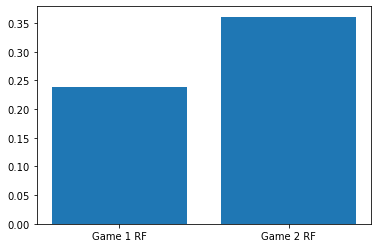

In [8]:
#6
plt.bar(['Game 1 RF', 'Game 2 RF'],[rel_freq_1, rel_freq_2]);

## Scenario 2

In [9]:
#1
fair_die = mc.Die(np.array([1,2,3,4,5,6]))

unfair_type1 = mc.Die(np.array([1,2,3,4,5,6]))
unfair_type1.change_weight(6, 5.0)

unfair_type2 = mc.Die(np.array([1,2,3,4,5,6]))
unfair_type2.change_weight(1, 5.0)

In [10]:
#2
game3 = mc.Game([fair_die, fair_die, fair_die, fair_die, fair_die])
game3.play(10000)

In [11]:
#3
game4 = mc.Game([unfair_type1, unfair_type1, unfair_type2, fair_die, fair_die])
game4.play(10000)

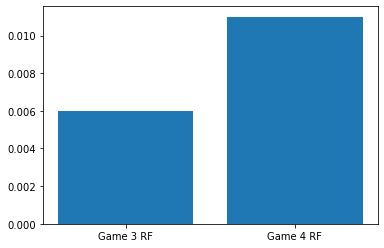

In [12]:
#4
game3_analyzed = mc.Analyzer(game3)
game4_analyzed = mc.Analyzer(game4)

game3_jackpots = game3_analyzed.jackpot()
game4_jackpots = game4_analyzed.jackpot()

rel_freq_3 = game3_jackpots / 1000
rel_freq_4 = game4_jackpots / 1000

plt.bar(['Game 3 RF', 'Game 4 RF'],[rel_freq_3, rel_freq_4]);

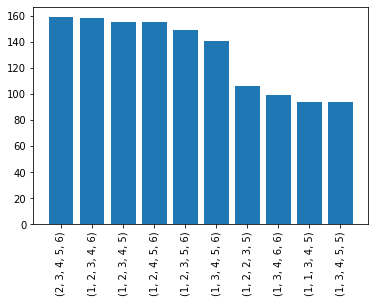

In [13]:
#5
game3_analyzed.combo()
game4_analyzed.combo()

top_combos_game3 = game3_analyzed.combinations.head(10)
top_combos_game4 = game4_analyzed.combinations.head(10)

labels3 = [str(x) for x in top_combos_game3.index]
plt.bar(labels3, top_combos_game3['n']);
plt.xticks(rotation = 'vertical');

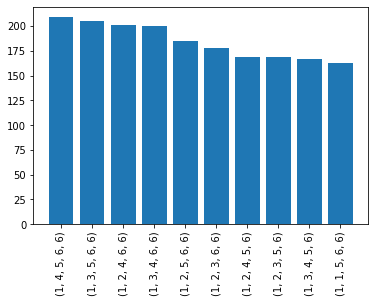

In [14]:
labels4 = [str(x) for x in top_combos_game4.index]
plt.bar(labels4, top_combos_game4['n']);
plt.xticks(rotation = 'vertical');

## Scenario 3

In [15]:
#1
letters = {'A': 8.4966, 'B': 2.0720, 'C': 4.5388, 'D': 3.3844, 'E': 11.1607, 
           'F': 1.8121, 'G': 2.4705, 'H': 3.0034, 'I': 7.5448, 'J': 0.1965, 
           'K': 1.1016, 'L': 5.4893, 'M': 3.0129, 'N': 6.6544, 'O': 7.1635, 
           'P': 3.1671, 'Q': 0.1962, 'R': 7.5809, 'S': 5.7351, 'T': 6.9509, 
           'U': 3.6308, 'V': 1.0074, 'W': 1.2899, 'X': 0.2902, 'Y': 1.7779, 
           'Z': 0.2722 }

letter_die = mc.Die(np.array(list(letters.keys())))
for i in range(len(letter_die.faces)):
    letter_die.change_weight(list(letters.keys())[i], \
                             list(letters.values())[i])

In [16]:
#2
game5 = mc.Game([letter_die, letter_die, letter_die, letter_die, letter_die])
game5.play(1000)

In [17]:
#game5.show()
game5.show().head(10)

die,0,1,2,3,4
roll,,,,,
0,O,T,T,O,U
1,R,E,E,A,L
2,N,I,O,H,H
3,A,L,U,T,E
4,S,A,D,U,C
5,H,E,E,N,O
6,W,E,L,N,B
7,A,A,E,F,C
8,L,E,N,R,M


##### #3
When looking through the combinations of the full table, I only found two rows that resembled English words. One was 'plots' and one was 'taste'

In [18]:
#4
rel_freq_5 = 2/1000
rel_freq_5

0.002

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [1]:
!ls -lRF -o

.:
total 144
-rw-r--r-- 1 jaw7cd 61799 Jul 15 17:57 FinalProjectSubmission.ipynb
-rw-r--r-- 1 jaw7cd  1064 Jul 15 17:31 LICENSE
drwxr-sr-x 3 jaw7cd  2048 Jul 15 17:32 montecarlo/
-rw-r--r-- 1 jaw7cd 39474 Jul 15 17:57 montecarlo_demo.ipynb
-rw-r--r-- 1 jaw7cd  1493 Jul 15 17:31 montecarlo_test_results.txt
-rw-r--r-- 1 jaw7cd  8123 Jul 15 17:31 README.md
-rw-r--r-- 1 jaw7cd   360 Jul 15 17:31 setup.py

./montecarlo:
total 36
-rw-r--r-- 1 jaw7cd   46 Jul 15 17:31 __init__.py
-rw-r--r-- 1 jaw7cd 8974 Jul 15 17:31 montecarlo.py
-rw-r--r-- 1 jaw7cd 5869 Jul 15 17:31 montecarlo_tests.py
drwxr-sr-x 2 jaw7cd  512 Jul 15 17:32 __pycache__/

./montecarlo/__pycache__:
total 16
-rw-r--r-- 1 jaw7cd 9753 Jul 15 17:32 montecarlo.cpython-38.pyc


# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [2]:
!pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /sfs/qumulo/qhome/jaw7cd/Documents/MSDS/5100/Montecarlo-Dice-Simulator
  Created wheel for montecarlo: filename=montecarlo-0.1-py3-none-any.whl size=6453 sha256=e9d8177263e4d0ff08b526a91baaf7f92f0085046fd138dfc023e253b77a5047
  Stored in directory: /sfs/qumulo/qhome/jaw7cd/.cache/pip/wheels/b5/da/25/e5f479e1e54bcc2ebb1355ffbd33cf7b2e15bda3f34a2c2485
Successfully built montecarlo
